# Q-learning for Dynamic Activation of Base Station Resources in Wireless Networks 

This work is inspired by the article "Reinforcement learning approach to dynamic activation of base station resources in wireless networks." by Peng-Yong Kong and Dorin Panaitopol on Personal Indoor and Mobile Radio Communications (PIMRC), 2013 IEEE 24th International Symposium on. IEEE, 2013. [1] 

## Introduction

We can consider a system in which a Base Station (BS) has several resources, these resources can be activated or deactivated by the system accordinly to some scheme or model. We propose a Q-learning algorithm to execute this process. this Q-learning model takes into account the number of users connected to the BS, the resources currently activated in the BS and it seeks to search a better energy efficiency while trying to avoid user blocking. 

A blocking happens when the number of users surpasses the maximum number of users tolerated by the BS, which is a function of the number of resources active at a given momment.

## Definitions
* Discrete Model
* Base Station with multiple resources
* Let m[n] be the number of active resources at a time slot n.
* So the Energy Consumption can be defined as P<sup>bs</sup> = P<sup>bs</sup> + m[n] P<sup>r</sup>

In [738]:
import pandas as pd
import numpy as np
import multiprocessing
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

In [739]:
def action_reward(u,m,a,M=30,U=50,P=-1000):
    if u<=(m+a)*U:
        R=M-m-a
    else:
        R=P
    return R

In [740]:
def pick_state(u,m,U=50,N=25):
    return m*(M*(U//N)+1)+math.ceil(u/N) 

In [751]:
def lambdan(n):
    beta=(20 + (8*math.sin(2*math.pi*(960+n)/1440)))*900/29
    b=math.ceil(beta)
    return np.random.randint(low=b-10,high=b+10+1)

In [752]:
def initiate_qtable(length,M=30,U=50,N=25,P=-1000):
    Q=np.zeros([length, M+1])
    for ii in range(0,M+1):
        for jj in range(0,M*U+1):
            state=pick_state(u=jj,m=ii,N=N,U=U)
            for col in range(0,M+1):
                a=col-ii
                if ((jj>(ii+a)*U) and (a<=0)):
                    Q[state][col]=P
    return Q

In [753]:
sns.set_style(style='darkgrid')

## System Parameters

In [754]:
Pcnt=100
Pr=30
M=30
U=50
N=25
P=-1000
epsilon=0.05
gamma=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alpha=[0.3, 0.5, 0.7]
maxEps=24*60*30

## Q-learning Parameters

In [755]:
un=30
mn=5
lenStateSpace=(M+1)*(M*(U//N)+1)

## Initialize Q-Table

In [756]:
vtBlock=np.zeros([len(alpha),len(gamma)])
vtEnS=np.zeros([len(alpha),len(gamma)])
for rate in range(0,len(alpha)):
    alphan=alpha[rate]
    for discount in range(0,len(gamma)):
        gamman=gamma[discount]
        Q=initiate_qtable(length=lenStateSpace,M=M,U=U,N=N,P=P)
        m0=3
        pblock=0
        EnS=0
        for epoch in range(0,maxEps):
            u0=lambdan(epoch)
            state0=pick_state(u=u0,m=m0,N=N,U=U)
            if np.random.rand()<epsilon:
                a=np.random.randint(low=0,high=M+1)-m0
            else: 
                a=Q[state0].argmax()-m0
            m1=m0+a
            state1=pick_state(u=u0,m=m1,N=N,U=U)
            r=action_reward(u=u0,m=m0,a=a,M=30,U=50,P=-1000)
            if r==P:
                pblock=pblock+1
            Q[state0][a+m0]=(1-alphan)*Q[state0][a+m0] + alphan*(r + gamman*(Q[state1].max()))
            m0=m1
            EnS=EnS+(M-m0)
        vtBlock[rate][discount]=pblock
        vtEnS[rate][discount]=EnS

In [757]:
vtBlock=vtBlock/maxEps

In [758]:
vtEnS=(vtEnS/maxEps)*100/M

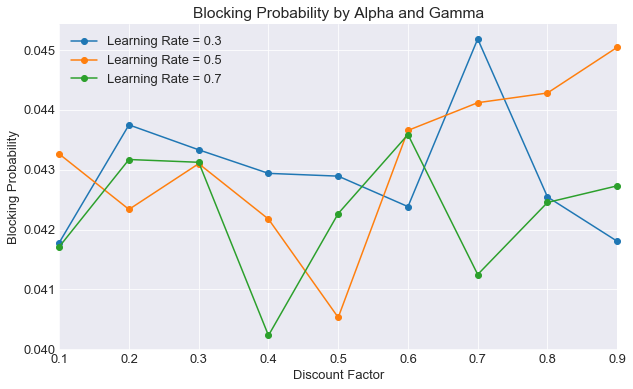

In [759]:
dfBlock=pd.DataFrame(vtBlock.T,index=gamma,columns=alpha)
dfBlock.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Blocking Probability')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Blocking Probability by Alpha and Gamma')
plt.rc('font',size=13)
plt.show()

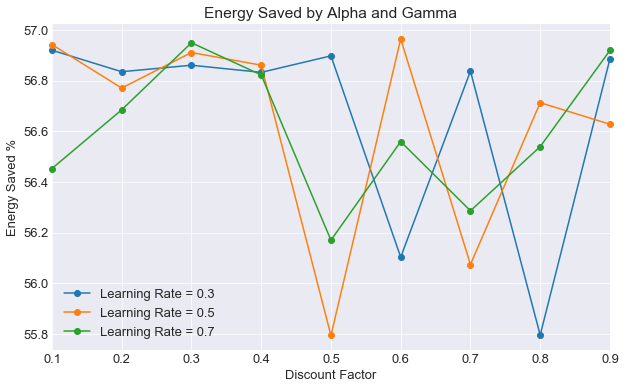

In [760]:
dfEnS=pd.DataFrame((vtEnS).T,index=gamma,columns=alpha)
dfEnS.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Energy Saved %')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Energy Saved by Alpha and Gamma')
plt.rc('font',size=13)
plt.show()

[1] Kong, Peng-Yong, and Dorin Panaitopol. "Reinforcement learning approach to dynamic activation of base station resources in wireless networks." *Personal Indoor and Mobile Radio Communications (PIMRC), 2013 IEEE 24th International Symposium* on. IEEE, 2013.

In [710]:
24*60*30

43200

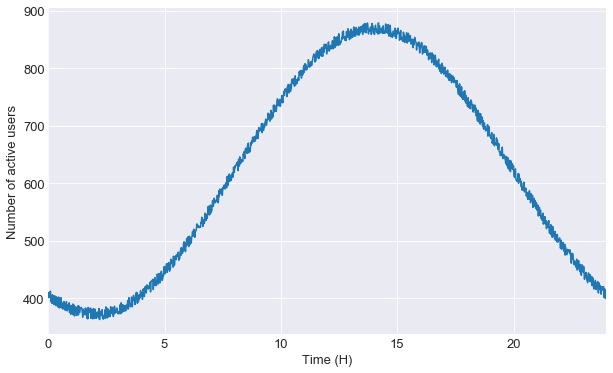

In [769]:
vtU=[]
for ii in range(0,60*24):
    vtU.append(lambdan(ii))
seU=pd.Series(vtU)
seU.index=seU.index/60
seU.plot(figsize=(10,6))
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()

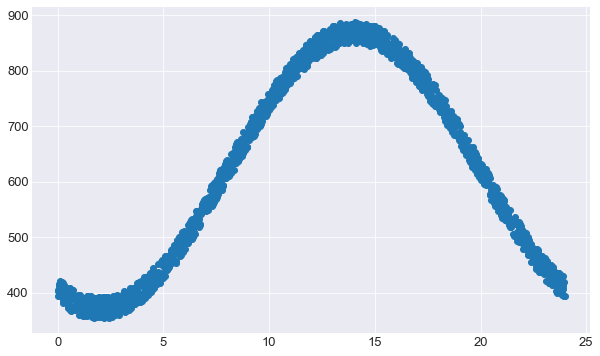

In [764]:
plt.figure(figsize=(10,6))
plt.scatter(x=seU.index/60,y=seU.values)